##Face Image Retrieval Using Deep Learning Models

**Author**:
- Trần Ngọc Tuấn - 21280058
***

**<center><font size=5>OVER VIEW</font></center>**

## What is a convolutional neural network algorithm?

Mạng neural tích chập (ConvNet / Convolutional Neural Networks - CNN) là một thuật toán học sâu có thể nhận vào một hình ảnh đầu vào và phân tách các khía cạnh/đối tượng khác nhau trong hình ảnh. CNN là một kiến trúc mạng cho học sâu học trực tiếp từ dữ liệu. CNNs đặc biệt hữu ích trong việc tìm ra các mẫu trong hình ảnh để nhận biết các đối tượng, lớp và danh mục. Chúng cũng có thể rất hiệu quả trong việc phân loại âm thanh, dữ liệu chuỗi thời gian và tín hiệu.

# <a id='intro'>1. Project Overview and Objectives</a>


## **Data Set Description**
### Overall

- 202,599 hình ảnh khuôn mặt của các người nổi tiếng khác nhau.

- 40 binary attribute annotations cho mỗi hình ảnh.

- 5 vị trí landmark.

### Data Files
- <b>img_celeba_orginal.zip</b>: Tất cả các hình ảnh khuôn mặt gốc.

- <b>list_eval_partition.txt</b>: Phân chia các hình ảnh thành các tập train, val, test. Hình ảnh từ 1 đến 162770 là train, từ 162771 đến 182637 là tập val, từ 182638 đến 202599 là test.

- <b>list_bbox_celeba.txt</b>: Thông tin về Bounding box cho mỗi hình ảnh. "x_1" và "y_1" đại diện cho tọa độ điểm trên cùng bên trái của bounding box. "width" và "height" đại diện cho chiều rộng và chiều cao của bounding box.

- <b>list_landmarks_celeba.txt</b>:  Các điểm landmarks trên hình ảnh và các tọa độ tương ứng của chúng. Có 5 điểm landmarks: : left eye, right eye, nose, left mouth, right mouth.

- <b>list_attr_celeba.txt</b>: Các label đặc điểm cho mỗi tấm ảnh. Có 40 attributes. "1" đại diện cho sự xuất hiện của đặc điểm còn "-1" đại diện cho sự không xuất hiện của đặc điểm.

## **Project Purpose**

- Project tập trung vào phát triển một mô hình Convolutional Neural Network (CNN) có khả năng dự đoán vị trí của bounding box, landmarks và các đặc điểm liên quan đến đối tượng trong ảnh.

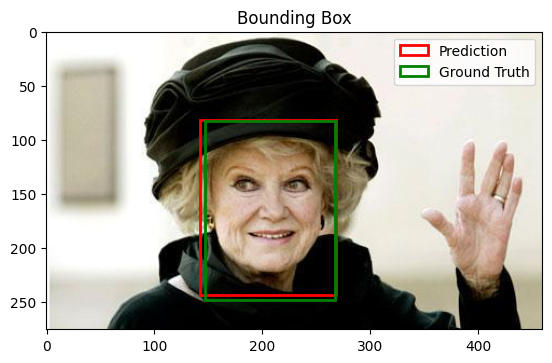

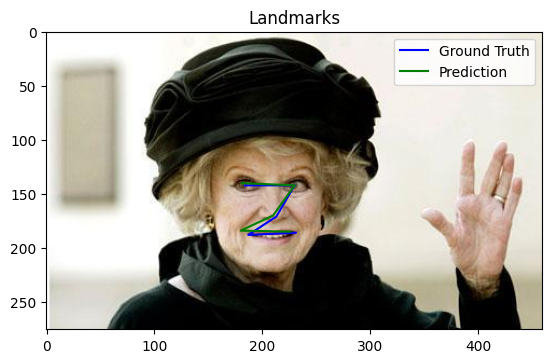

# <a id='env'>2. Setting up the Libraries</a>

In [ ]:
import os
import shutil
import logging
import re
import cv2
import concurrent.futures
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# <a id='import'>3. Data Import and Preprocessing</a>

## **Define Data Path**

In [ ]:
DATA_FOLDER_PATH = '/content/drive/MyDrive/CNN/'
IMAGE_PATH = DATA_FOLDER_PATH + 'Image/img_celeba_orginal.zip'
BBOX_PATH = DATA_FOLDER_PATH + 'Anno/list_bbox_celeba.txt'
LANDMARKS_PATH = DATA_FOLDER_PATH + 'Anno/list_landmarks_celeba.txt'
EVAL_PARTITION_PATH = DATA_FOLDER_PATH + 'Eval/list_eval_partition.txt'
RESCALED_KEYPOINTS_PATH = DATA_FOLDER_PATH + 'Anno/list_rescaled_keypoints_celeba.csv'
WIDTH_HEIGHT_PATH = DATA_FOLDER_PATH + 'Anno/list_width_height_original_celeba.csv'
BBOX_LANDMARKS_MODEL_PATH = DATA_FOLDER_PATH + 'Model/bbox_landmarks_model_checkpoint.h5'
ATTRIBUTE_MODEL_PATH = DATA_FOLDER_PATH + 'Model/attr_model_checkpoint.h5'
CUSTOM_IMAGE_TEST = DATA_FOLDER_PATH + 'Test/'

In [ ]:
HOME = '/content/'
IMAGE = HOME + 'images/'

## **Preprocessing Data Exploration**

We are going to use the CelebA Dataset.

### **Load Data**

#### **Unzip Images**

In [ ]:
## Unzip original images
if os.path.exists(IMAGE):
  shutil.rmtree(IMAGE)
!unzip -j $IMAGE_PATH -d $IMAGE

In [ ]:
images_folder = os.listdir(IMAGE)
images_folder.sort()
total_images = len(images_folder)

print(f"There are {total_images} images in the dataset.")

There are 202599 images in the dataset.


#### **Load original keypoints of Boungding Box and Landmarks**

In [ ]:
## Read keypoints in txt file
def read_dataset(file_path: str, cols: str):
  with open(file=file_path, mode='r') as f:
    # Skip the first 2 rows
    lines = f.readlines()[2:]
    lines = [line.strip() for line in lines]
    lines = [line.split() for line in lines]

    f.close()

  # Convert to pandas dataframe
  df = pd.DataFrame(lines, columns=cols)
  return df

## Load the keypoints of Bounding Box and Landmarks of Celeb A
bbox_df = read_dataset(file_path=BBOX_PATH, cols=['image_id', 'x_1', 'y_1', 'width', 'height'])
landmarks_df = read_dataset(file_path=LANDMARKS_PATH, cols=['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'])

In [ ]:
## Combine into final dataframe
bbox_landmarks_df = pd.merge(bbox_df, landmarks_df, on='image_id')
images_folder = os.listdir(IMAGE)
bbox_landmarks_df = bbox_landmarks_df[bbox_landmarks_df['image_id'].isin(images_folder)]

In [ ]:
## Change dtypes
dtypes_dict = {col: 'float' for col in bbox_landmarks_df.columns[1:]}
bbox_landmarks_df = bbox_landmarks_df.astype(dtypes_dict)

In [ ]:
bbox_landmarks_df.head()

,image_id,x_1,y_1,width,height,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,95.0,71.0,226.0,313.0,165.0,184.0,244.0,176.0,196.0,249.0,194.0,271.0,266.0,260.0
1,000002.jpg,72.0,94.0,221.0,306.0,140.0,204.0,220.0,204.0,168.0,254.0,146.0,289.0,226.0,289.0
2,000003.jpg,216.0,59.0,91.0,126.0,244.0,104.0,264.0,105.0,263.0,121.0,235.0,134.0,251.0,140.0
3,000004.jpg,622.0,257.0,564.0,781.0,796.0,539.0,984.0,539.0,930.0,687.0,762.0,756.0,915.0,756.0
4,000005.jpg,236.0,109.0,120.0,166.0,273.0,169.0,328.0,161.0,298.0,172.0,283.0,208.0,323.0,207.0


### **Show sample images**

In [ ]:
## Choose first 2 records
sample_data = bbox_landmarks_df.iloc[0, :]
sample_data

image_id        000001.jpg
x_1                   95.0
y_1                   71.0
width                226.0
height               313.0
lefteye_x            165.0
lefteye_y            184.0
righteye_x           244.0
righteye_y           176.0
nose_x               196.0
nose_y               249.0
leftmouth_x          194.0
leftmouth_y          271.0
rightmouth_x         266.0
rightmouth_y         260.0
Name: 0, dtype: object

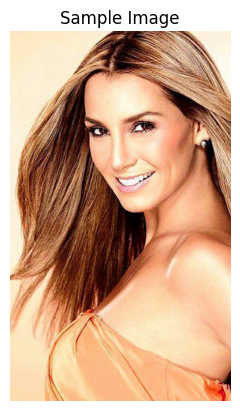

In [ ]:
def show_image(img_path: str, title: str ="Image"):
  # Read the image
  img = mpimg.imread(img_path)

  # Display the image
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

show_image(IMAGE + sample_data['image_id'], title="Sample Image")

In [ ]:
def draw_bbox(image: Image, bbox: list[int], title: str = "Bounding Box"):
  fig, ax = plt.subplots(1)
  ax.imshow(image)

  # Create a Rectangle patch
  rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.title(title)
  plt.axis('off')
  plt.show()

def draw_landmarks(image: Image, landmarks: list[int], title: str = "Landmarks"):
    landmarks_array = np.array(landmarks).reshape(-1, 2)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot each landmark as a red dot
    ax.plot(landmarks_array[:, 0], landmarks_array[:, 1], 'b')

    plt.title(title)
    plt.show()

In [ ]:
sample_image = Image.open(IMAGE + sample_data['image_id'])
sample_bbox = sample_data[['x_1', 'y_1', 'width', 'height']]
sample_landmarks = sample_data[['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']]

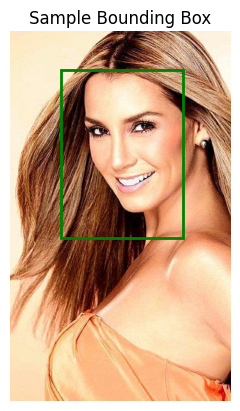

In [ ]:
draw_bbox(sample_image, sample_bbox, title="Sample Bounding Box")

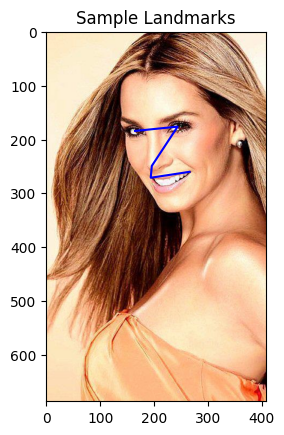

In [ ]:
draw_landmarks(sample_image, sample_landmarks, title="Sample Landmarks")

### **Scale / Resize Image, BBox and Landmarks Keypoints**

#### **Visualization**

In [ ]:
## Extract height and width of an image
def get_width_height(img_path: str):
  img = cv2.imread(img_path)
  height, width, _ = img.shape
  return width, height

In [ ]:
DEFAULT_WIDTH = 224
DEFAULT_HEIGHT = 224

In [ ]:
# original_images_size = [get_width_height(IMAGE + img_name) for img_name in images_folder]

In [ ]:
# original_images_size_df = pd.DataFrame(original_images_size, columns=['width', 'height'])
original_images_size_df = pd.read_csv(WIDTH_HEIGHT_PATH)
original_images_size_df.columns = ['width', 'height']
original_images_size_df.head()

,width,height
0,409,687
1,423,594
2,500,281
3,1648,2464
4,610,826


In [ ]:
# original_images_size_df.to_csv('width_height_original.csv', index=False)

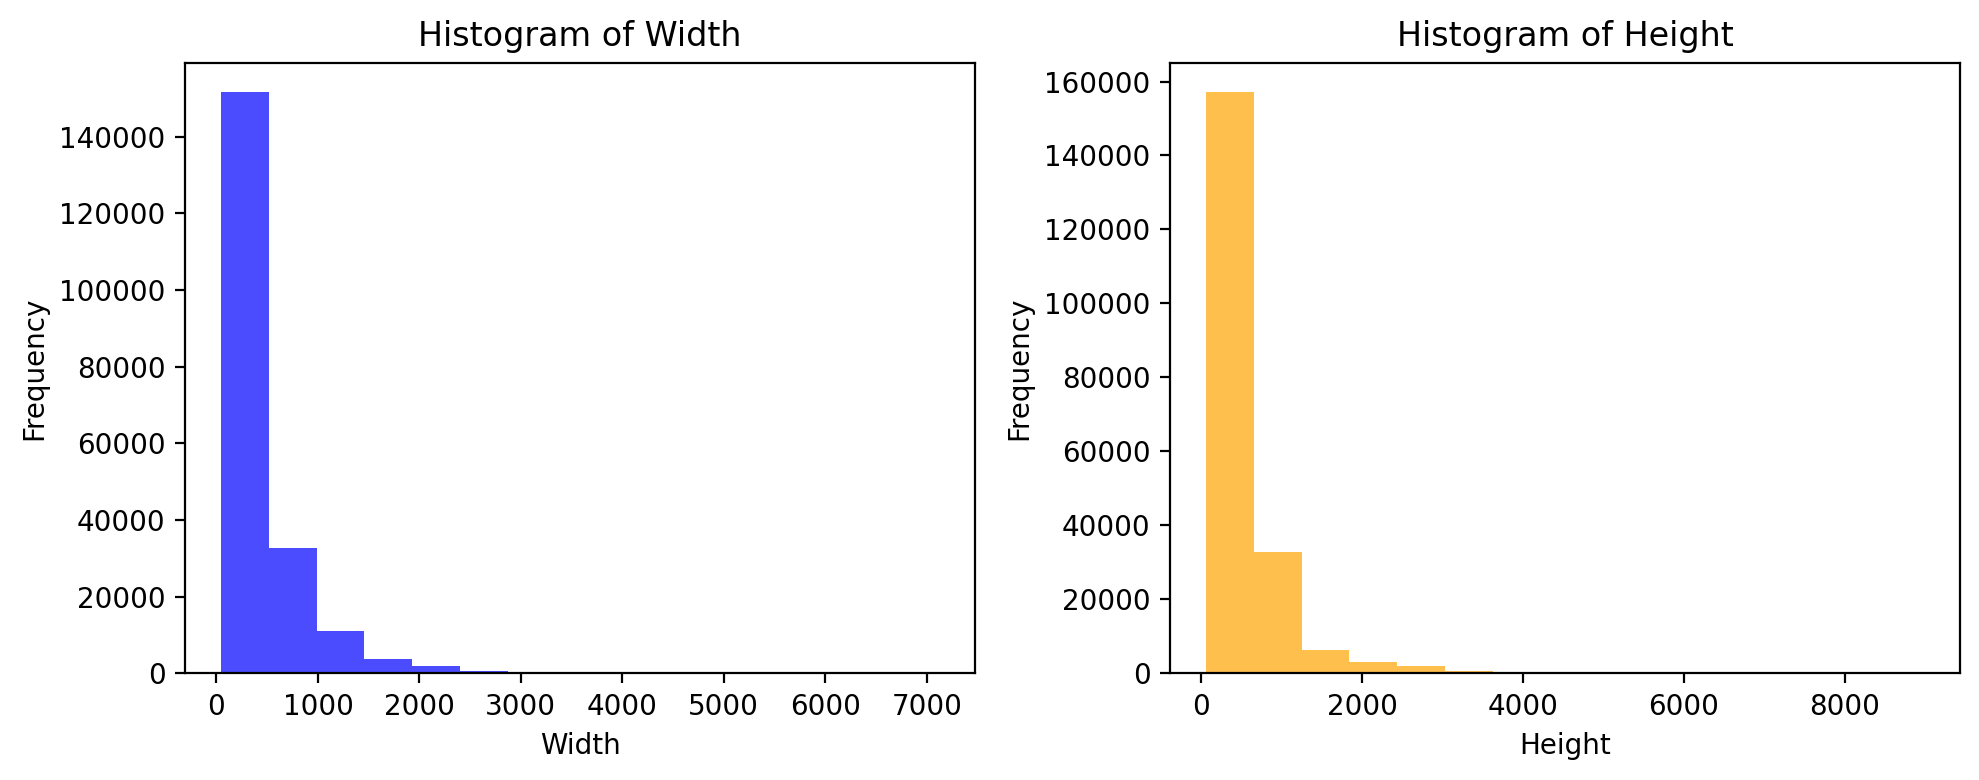

In [ ]:
plt.figure(figsize=(10, 4), dpi=200)

plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot in the 1st subplot
plt.hist(original_images_size_df['width'], bins=15, alpha=0.7, color='blue')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Histogram of Width')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot in the 2nd subplot
plt.hist(original_images_size_df['height'], bins=15, alpha=0.7, color='orange')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Histogram of Height')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### **Resize**

In [ ]:
## Calculate scaling factor by dividing new size by old size
scale_factor_df = (DEFAULT_WIDTH, DEFAULT_HEIGHT) / original_images_size_df
scale_factor = np.tile(scale_factor_df.values, (1, bbox_landmarks_df.shape[1] // 2))

In [ ]:
scale_factor

array([[0.54767726, 0.32605531, 0.54767726, ..., 0.32605531, 0.54767726,
        0.32605531],
       [0.52955083, 0.37710438, 0.52955083, ..., 0.37710438, 0.52955083,
        0.37710438],
       [0.448     , 0.79715302, 0.448     , ..., 0.79715302, 0.448     ,
        0.79715302],
       ...,
       [0.98245614, 0.78596491, 0.98245614, ..., 0.78596491, 0.98245614,
        0.78596491],
       [0.41869159, 0.60053619, 0.41869159, ..., 0.60053619, 0.41869159,
        0.60053619],
       [0.32369942, 0.21875   , 0.32369942, ..., 0.21875   , 0.32369942,
        0.21875   ]])

Chúng ta sẽ tính toán tỉ lệ scale ở x và y. Để lấy được giá trị scale từ giá trị gốc, chúng ta nhân với các biến với tỉ lệ scale tương ứng (x hoặc y)

In [ ]:
def scale(df: pd.DataFrame, scale_factor: np.array):
  final_df = df.copy()
  final_df.iloc[:, 1:] = final_df.iloc[:, 1:] * scale_factor
  final_df.iloc[:, 1:] = final_df.iloc[:, 1:].round(0).astype(int)
  return final_df

In [ ]:
bbox_landmarks_df = scale(df=bbox_landmarks_df, scale_factor=scale_factor)
bbox_landmarks_df

<ipython-input-62-3ac8f4dfa8ee>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_df.iloc[:, 1:] = final_df.iloc[:, 1:].round(0).astype(int)


,image_id,x_1,y_1,width,height,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,52,23,124,102,90,60,134,57,107,81,106,88,146,85
1,000002.jpg,38,35,117,115,74,77,117,77,89,96,77,109,120,109
2,000003.jpg,97,47,41,100,109,83,118,84,118,96,105,107,112,112
3,000004.jpg,85,23,77,71,108,49,134,49,126,62,104,69,124,69
4,000005.jpg,87,30,44,45,100,46,120,44,109,47,104,56,119,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,161,14,26,48,169,31,178,31,174,40,170,44,178,44
202595,202596.jpg,77,47,64,57,96,67,124,67,108,79,96,83,124,83
202596,202597.jpg,52,60,89,99,80,95,111,94,99,112,80,122,114,122
202597,202598.jpg,82,17,38,76,93,44,107,43,101,56,94,65,106,63


In [ ]:
# bbox_landmarks_df.to_csv(RESCALED_KEYPOINTS_PATH, index=False)

# <a id='cnn'>4. CNN Model</a>

In [ ]:
DEFAULT_WIDTH = 224
DEFAULT_HEIGHT = 224

## **Split Dataset**

In [ ]:
batch_size = 32

If I have done the preprocessing the data by rescaling all keypoints to new size (224, 224), then just load the saved rescaled keypoints csv

In [ ]:
rescaled_bbox_landmarks_df = pd.read_csv(RESCALED_KEYPOINTS_PATH)
rescaled_bbox_landmarks_df.head()

,image_id,x_1,y_1,width,height,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,52,23,124,102,90,60,134,57,107,81,106,88,146,85
1,000002.jpg,38,35,117,115,74,77,117,77,89,96,77,109,120,109
2,000003.jpg,97,47,41,100,109,83,118,84,118,96,105,107,112,112
3,000004.jpg,85,23,77,71,108,49,134,49,126,62,104,69,124,69
4,000005.jpg,87,30,44,45,100,46,120,44,109,47,104,56,119,56


In [ ]:
## Read list eval partition txt
eval_partition_df = pd.read_csv(EVAL_PARTITION_PATH, delimiter=' ', header=None)
eval_partition_df.columns = ['image_id', 'eval_status']

In [ ]:
eval_partition_df['eval_status'].value_counts()

0    162770
2     19962
1     19867
Name: eval_status, dtype: int64

Chúng ta chia tệp dữ liệu hình ảnh thành tập train, tập validation và tập test thành như sau:
* Từ 1 đến 162.770 là training
* Từ 162.771 đến 182.637 là validation
* Từ 182.638 đến 202.599 là testing

In [ ]:
training_partition_df = rescaled_bbox_landmarks_df[eval_partition_df['eval_status'] == 0].reset_index(drop=True)
validation_partition_df = rescaled_bbox_landmarks_df[eval_partition_df['eval_status'] == 1].reset_index(drop=True)
testing_partition_df = rescaled_bbox_landmarks_df[eval_partition_df['eval_status'] == 2].reset_index(drop=True)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=training_partition_df,
    directory=IMAGE,
    x_col='image_id',
    y_col=training_partition_df.columns.drop('image_id').tolist(),
    target_size=(DEFAULT_WIDTH, DEFAULT_HEIGHT),
    batch_size=batch_size,
    class_mode='raw',
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validation_partition_df,
    directory=IMAGE,
    x_col='image_id',
    y_col=validation_partition_df.columns.drop('image_id').tolist(),
    target_size=(DEFAULT_WIDTH, DEFAULT_HEIGHT),
    batch_size=batch_size,
    class_mode='raw',
)

test_generator = datagen.flow_from_dataframe(
    dataframe=testing_partition_df,
    directory=IMAGE,
    x_col='image_id',
    y_col=testing_partition_df.columns.drop('image_id').tolist(),
    target_size=(DEFAULT_WIDTH, DEFAULT_HEIGHT),
    batch_size=batch_size,
    class_mode='raw',
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.
Found 19962 validated image filenames.


## **Build Model**

### VGG16 Architecture Overview

VGG16, như tên của nó, là một 16-layer deep neural network. Nó là một mạng khá rộng lớn với tổng cộng 138 triệu tham số, là một con số khá lớn ngay cả đối với tiêu chuẩn hiện nay. Tuy nhiên, tính đơn giản của kiến trúc VGGNet16 là điểm hấp dẫn chính của nó.

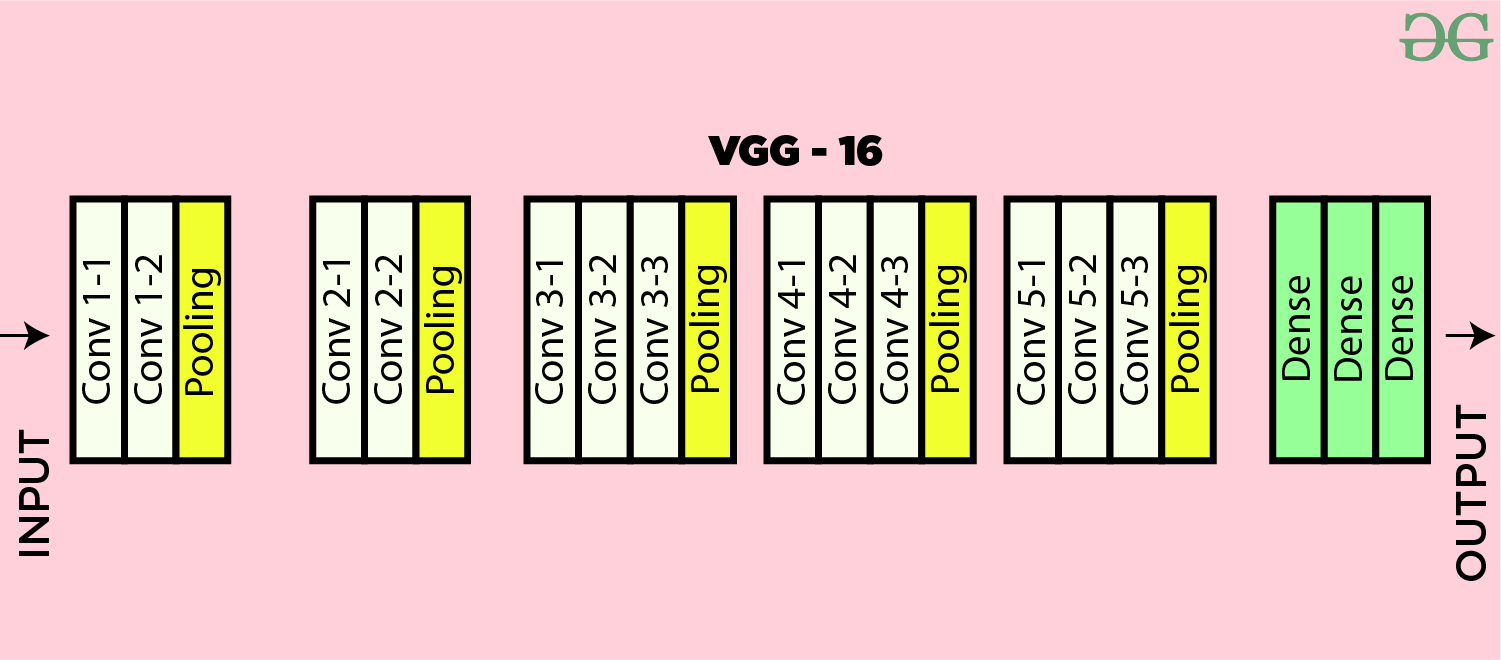

### Architecture Details

### Input
- VGGNet nhận đầu vào là hình ảnh có kích thước 224×224x3.

### Convolutional Layers
- Convolutional filters của VGG sử dụng kích thước 3x3.

### ReLu Activation
- Tiếp theo hàm kích hoạt là Rectified Linear Unit (ReLU), ReLU là một hàm tuyến tính cung cấp đầu ra phù hợp cho các đầu vào dương và đầu ra bằng không cho các đầu vào âm.

### Pooling Layers
- Một pooling layer được thêm vào sau một số tầng tích chập, giúp giảm  số lượng tham số ở mỗi bước tích chập.

### Fully Connected Layers
- VGGNet bao gồm ba layer kết nối đầy đủ.
- Hai lớp đầu tiên mỗi lớp có 4096 node và lớp thứ ba có số lượng node bằng với số lượng output của mô hình.
- Với bài toán phân loại thì ta có thể thêm vào 1 hàm softmax.

In [ ]:
## Define layers property

# Input
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

# Conv2D
CONV2D_PADDING = 'same'
CONV2D_KERNEL_SIZE = (3, 3)
CONV2D_STRIDES = 1
CONV2D_ACT_FUNC = 'leaky_relu'

# MaxPool2D
MAXPOOL_POOL_SIZE = (2, 2)
MAXPOOL_STRIDES = 2

# Fully Connected
FC_ACT_FUNC = 'linear'

# Dropout
DROP_OUT_PROB = 0.2

# Output
OUTPUT_NUM = 4

In [ ]:
# Define the model
bbox_landmarks_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=64, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC, input_shape=(HEIGHT, WIDTH, CHANNELS)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(MAXPOOL_POOL_SIZE, strides=MAXPOOL_STRIDES),
  tf.keras.layers.Dropout(DROP_OUT_PROB),

  tf.keras.layers.Conv2D(filters=128, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=128, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(MAXPOOL_POOL_SIZE, strides=MAXPOOL_STRIDES),
  tf.keras.layers.Dropout(DROP_OUT_PROB),

  tf.keras.layers.Conv2D(filters=256, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=256, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=256, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(MAXPOOL_POOL_SIZE, strides=MAXPOOL_STRIDES),
  tf.keras.layers.Dropout(DROP_OUT_PROB),

  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(MAXPOOL_POOL_SIZE, strides=MAXPOOL_STRIDES),
  tf.keras.layers.Dropout(DROP_OUT_PROB),

  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.Conv2D(filters=512, kernel_size=CONV2D_KERNEL_SIZE, padding=CONV2D_PADDING, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(MAXPOOL_POOL_SIZE, strides=MAXPOOL_STRIDES),
  tf.keras.layers.Dropout(DROP_OUT_PROB),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(4096, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(4096, activation=CONV2D_ACT_FUNC),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(14, activation=FC_ACT_FUNC)
])

# Compile the model
bbox_landmarks_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Summary the model
bbox_landmarks_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_7 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)    

In [ ]:
bbox_landmarks_model_checkpoint_callback = ModelCheckpoint(
    filepath=BBOX_LANDMARKS_MODEL_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

## **Train Model**

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
## Load weights from checkpoint
if os.path.exists(BBOX_LANDMARKS_MODEL_PATH):
  bbox_landmarks_model.load_weights(BBOX_LANDMARKS_MODEL_PATH)

In [ ]:
bbox_landmarks_hist = bbox_landmarks_model.fit(x=train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=2,
          callbacks=[bbox_landmarks_model_checkpoint_callback]
)

Epoch 1/2
5086/5086 [==============================] - ETA: 0s - loss: 299.7913 - mean_absolute_error: 8.9935
Epoch 1: val_loss improved from inf to 57.64366, saving model to /content/checkpint.h5
5086/5086 [==============================] - 3804s 741ms/step - loss: 299.7913 - mean_absolute_error: 8.9935 - val_loss: 57.6437 - val_mean_absolute_error: 5.0052
Epoch 2/2
5086/5086 [==============================] - ETA: 0s - loss: 55.7201 - mean_absolute_error: 5.3262
Epoch 2: val_loss improved from 57.64366 to 37.75739, saving model to /content/checkpint.h5
5086/5086 [==============================] - 3766s 740ms/step - loss: 55.7201 - mean_absolute_error: 5.3262 - val_loss: 37.7574 - val_mean_absolute_error: 4.0078


In [ ]:
bbox_landmarks_hist.history['mean_absolute_error']

[8.993467330932617, 5.326242923736572]

### **Loss Visualizing**

In [ ]:
def visualize_training(history, lw=3, model_name=''):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot([i for i in range(1, len(history.history['mean_absolute_error']) + 1)], history.history['mean_absolute_error'], label = 'training', marker = '*', linewidth = lw)
    plt.plot([i for i in range(1, len(history.history['val_mean_absolute_error']) + 1)], history.history['val_mean_absolute_error'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Mean absolute error of ' + model_name)
    plt.xlabel('Epochs')
    # plt.ylabel('Error')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')

    plt.subplot(2,1,2)
    plt.plot([i for i in range(1, len(history.history['loss']) + 1)], history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot([i for i in range(1, len(history.history['val_loss']) + 1)], history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison of ' + model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()

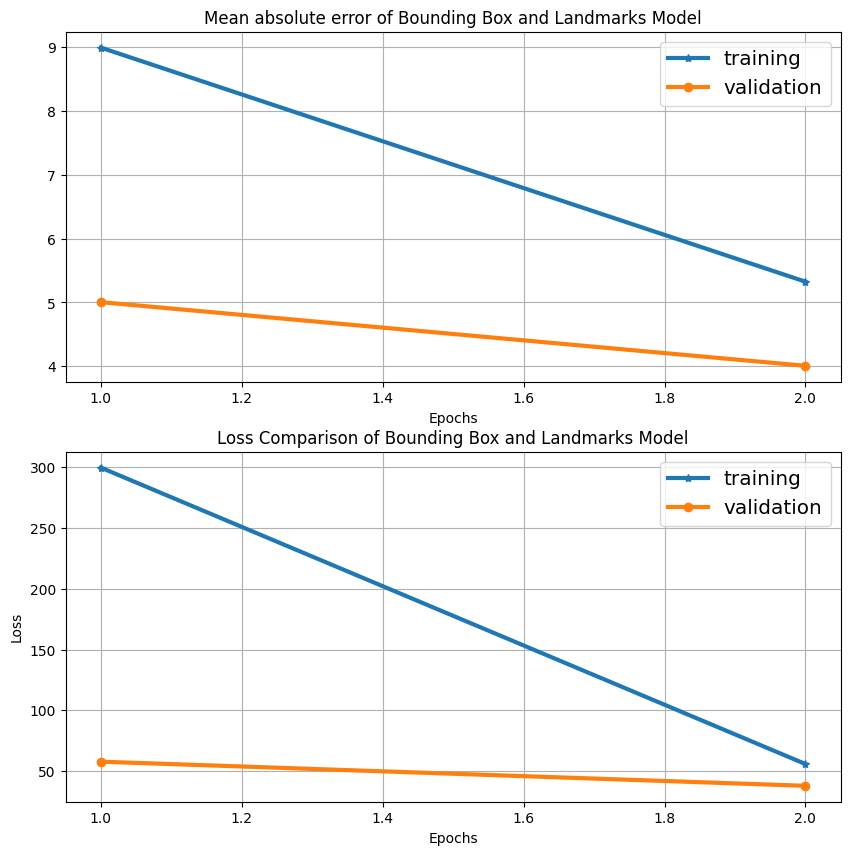

In [ ]:
visualize_training(bbox_landmarks_hist, model_name='Bounding Box and Landmarks Model')

## **Evaluation**

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
def draw_bbox(image: Image, bbox: list[int], title: str = "Bounding Box", bbox_pred: list[int] = None):
  fig, ax = plt.subplots(1)
  ax.imshow(image)

  # Create a Rectangle patch
  rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')

  if bbox_pred is not None:
    rect_pred = patches.Rectangle((bbox_pred[0], bbox_pred[1]), bbox_pred[2], bbox_pred[3], linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
    ax.add_patch(rect_pred)

  # Add the patch to the Axes
  ax.add_patch(rect)

  # Show legend
  if bbox_pred is not None:
    ax.legend()

  plt.title(title)
  # plt.axis('off')
  plt.show()

def draw_landmarks(image: Image, landmarks: list[int], title: str = "Landmarks", landmarks_pred: list[int] = None):
    landmarks_array = np.array(landmarks).reshape(-1, 2)
    landmarks_pred_array = np.array(landmarks_pred).reshape(-1, 2)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot each landmark as a red dot
    ax.plot(landmarks_array[:, 0], landmarks_array[:, 1], "b", label="Ground Truth")

    if landmarks_pred is not None:
      ax.plot(landmarks_pred_array[:, 0], landmarks_pred_array[:, 1], "g", label="Prediction")
      ax.legend()

    plt.title(title)
    plt.show()

def draw_bbox_and_landmarks(image: Image, bbox: list[int], landmarks: list[int], title: str = "Bounding Box and Landmarks", bbox_pred: list[int] = None, landmarks_pred: list[int] = None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Create a Rectangle patch for bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth BBox')

    if bbox_pred is not None:
        rect_pred = patches.Rectangle((bbox_pred[0], bbox_pred[1]), bbox_pred[2], bbox_pred[3], linewidth=2, edgecolor='r', facecolor='none', label='Prediction BBox')
        ax.add_patch(rect_pred)

    # Add the bounding box patch to the Axes
    ax.add_patch(rect)

    # Plot landmarks as blue dots
    landmarks_array = np.array(landmarks).reshape(-1, 2)
    ax.plot(landmarks_array[:, 0], landmarks_array[:, 1], "b", label="Ground Truth Landmarks")

    if landmarks_pred is not None:
        landmarks_pred_array = np.array(landmarks_pred).reshape(-1, 2)
        ax.plot(landmarks_pred_array[:, 0], landmarks_pred_array[:, 1], "g", label="Prediction Landmarks")

    # Show legend if both bounding box and landmarks are present
    if bbox_pred is not None and landmarks_pred is not None:
        ax.legend()

    plt.title(title)
    plt.show()

In [ ]:
def get_width_height(img_path: str):
  img = cv2.imread(img_path)
  height, width, _ = img.shape
  return width, height

def resize_image(input_path: str, new_size: tuple):
  with Image.open(input_path) as image:
    resized_image = image.resize(new_size)
    return resized_image

def get_image_scale_factor(img_path: str, model):
  test_width, test_height = get_width_height(img_path)
  scale_x = DEFAULT_WIDTH / test_width
  scale_y = DEFAULT_HEIGHT / test_height
  scale_x_y = np.array([scale_x, scale_y])

  num_outputs = model.get_layer(index=-1).units
  scale_factor = np.tile(scale_x_y, (1, num_outputs // 2))

  return scale_factor

def make_prediction(img_path: str, model):
  scale_factor = get_image_scale_factor(img_path, model)
  resized_image = resize_image(img_path, (DEFAULT_WIDTH, DEFAULT_HEIGHT))
  test_image_array = np.asarray(resized_image) / 255.

  rescaled_test_image_prediction = model.predict(np.array([test_image_array], None))[0]
  original_test_image_prediction = rescaled_test_image_prediction / scale_factor
  original_test_image_prediction = np.round(original_test_image_prediction).astype(int)

  return original_test_image_prediction

### **Test Set**

In [ ]:
## Load weights from checkpoint
bbox_landmarks_model.load_weights(BBOX_LANDMARKS_MODEL_PATH)

In [ ]:
bbox_landmarks_model.evaluate(x=test_generator, steps=STEP_SIZE_TEST)

623/623 [==============================] - 125s 183ms/step - loss: 11.3837 - mean_absolute_error: 1.9439


[11.383699417114258, 1.9438841342926025]

- Loss: 11.383699417114258
- Sai số trung bình tuyệt đối (Mean Absolute Error): 1.9438841342926025

Giá trị loss thấp hơn là mong muốn, điều này chỉ ra hiệu suất tốt hơn của mô hình trong việc giảm thiểu chênh lệch giữa giá trị dự đoán và giá trị thực tế. Sai số trung bình tuyệt đối là 1.9445, cho thấy trung bình, dự đoán của mô hình chênh lệch khoảng 1.9445 đơn vị so với giá trị thực tế. Tổng thể, kết quả này cho thấy mô hình có hiệu suất khá tốt, nhưng việc đánh giá cần xem xét thêm theo yêu cầu cụ thể và ngữ cảnh của công việc.

In [ ]:
## Choose one image in test set
sample_test_image_name = testing_partition_df.loc[0, "image_id"]
sample_test_image_path = IMAGE + sample_test_image_name
sample_test_image = Image.open(sample_test_image_path)


sample_test_data = bbox_landmarks_df.iloc[int(sample_test_image_name.split(".")[0]) - 1]

In [ ]:
sample_rescaled_bbox_original = sample_test_data[['x_1', 'y_1', 'width', 'height']]
sample_bbox_original = sample_rescaled_bbox_original.astype(int)

sample_rescaled_landmarks_original = sample_test_data[['lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']]
sample_landmarks_original = sample_rescaled_landmarks_original.astype(int)

In [ ]:
sample_test_data_prediction = make_prediction(sample_test_image_path, model=bbox_landmarks_model)[0]
sample_bbox_prediction = sample_test_data_prediction[:4].astype(int)
sample_landmarks_prediction = sample_test_data_prediction[4:].astype(int)

1/1 [==============================] - 5s 5s/step


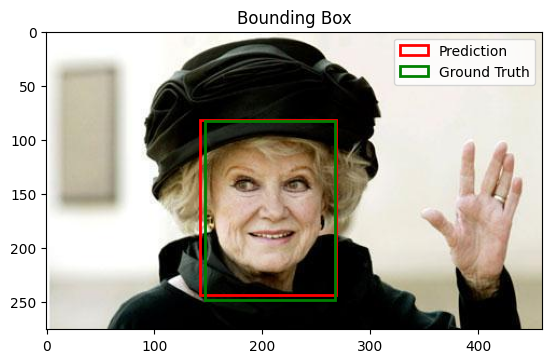

In [ ]:
draw_bbox(sample_test_image, sample_bbox_original, bbox_pred=sample_bbox_prediction)

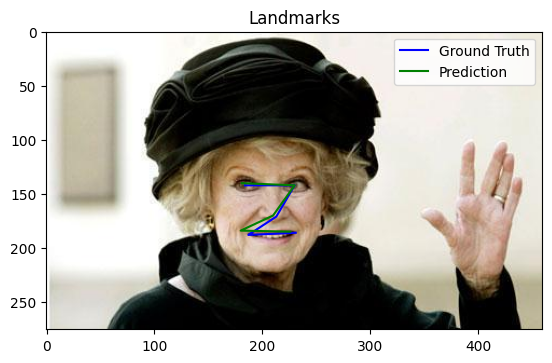

In [ ]:
draw_landmarks(sample_test_image, sample_landmarks_original, landmarks_pred=sample_landmarks_prediction)

### **New Unseen Data**

In [ ]:
def images_prediction(img_paths: str, model):
  predictions = []

  for img_path in img_paths:
    scale_factor = get_image_scale_factor(img_path, model)

    resized_img = resize_image(img_path, new_size=(DEFAULT_WIDTH, DEFAULT_HEIGHT))
    resized_img_arr = np.asarray(resized_img) / 255.

    pred = model.predict(np.array([resized_img_arr], None))
    predictions.append(pred / scale_factor)

  return predictions

In [ ]:
unseen_img_paths = [CUSTOM_IMAGE_TEST + img_name for img_name in os.listdir(CUSTOM_IMAGE_TEST)]

In [ ]:
predictions = images_prediction(unseen_img_paths, model=bbox_landmarks_model)

1/1 [==============================] - 0s 34ms/step


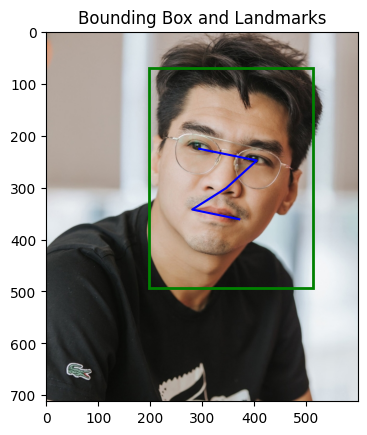

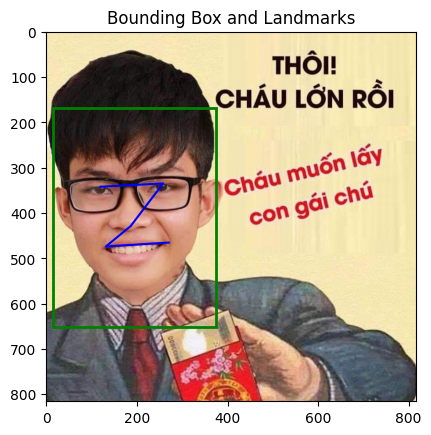

In [ ]:
for unseen_img_path, pred in zip(unseen_img_paths[:5], predictions[:5]):
  unseen_img = Image.open(unseen_img_path)
  unseen_bbox = pred[0][:4]
  unseen_landmarks = pred[0][4:]
  draw_bbox_and_landmarks(unseen_img, unseen_bbox, unseen_landmarks)

# <a id='concl'>5. Conclusions</a>

Project triển khai mô hình VGG để nhận diện và dự đoán vị trí của bounding box, landmarks và các đặc điểm liên quan đối với đối tượng trong ảnh. Kết quả cho thấy rằng mô hình đã đạt được mức độ hiệu suất đáng kể, với Loss đạt mức 11.38 và Sai số trung bình tuyệt đối (Mean Absolute Error) ở mức 1.94 trên tập test.

- Chỉ số Loss thấp cho thấy rằng mô hình đã học được cách giảm thiểu sai lệch giữa các dự đoán và giá trị thực tế của vị trí bounding box và landmarks.

- Sai số trung bình tuyệt đối (Mean Absolute Error) ở mức 1.94 chỉ ra rằng mức độ sai lệch trung bình giữa dự đoán của mô hình và giá trị thực tế của vị trí bounding box và landmarks là khá thấp.

Tóm lại, dự án đã đạt được những kết quả quan trọng trong việc nhận diện và dự đoán vị trí của bounding box, landmarks và các đặc điểm liên quan đến đối tượng trong ảnh, mở ra ứng dụng trong thực tế, như trong lĩnh vực xử lý ảnh y tế, an ninh và nhận dạng khuôn mặt.

### Những khó khăn mà nhóm đã gặp trong quá trình triển khai dự án:
1. **Quản lý Dữ Liệu Khối Lượng Lớn**: Với số lượng lớn ảnh trong tập dữ liệu, việc load toàn bộ dữ liệu vào bộ nhớ một lần gây ra vấn đề về tài nguyên và hiệu suất. Điều này đặc biệt trở nên phức tạp khi không đủ bộ nhớ để load toàn bộ dữ liệu cùng một lúc.

2. **Thời Gian Train Dài**: Cấu trúc phức tạp của mô hình, bao gồm nhiều lớp và nhiều tham số, làm tăng đáng kể thời gian huấn luyện. Việc mỗi epoch tốn gần 1 tiếng không chỉ là một vấn đề về thời gian mà còn là một vấn đề về tài nguyên máy tính.

3. **Tối Ưu Hóa Quá Trình Huấn Luyện**: Cần phải tìm kiếm các phương pháp tối ưu hóa quá trình huấn luyện để giảm thiểu thời gian và tài nguyên cần thiết. Điều này có thể bao gồm sử dụng tài nguyên tính toán mạnh mẽ hơn, lưu lại checkpoint sau mỗi epoch train, ...


